In [1]:
from ccsopt.utils import setrootdir

setrootdir("ccsopt")

'Directory ccsopt successfully loaded as current working directory.'

In [2]:
import numpy as np
import pandas as pd
from ccsopt.predictor import ConcreteCompressiveStrengthPredictor

In [3]:
df = pd.read_excel("data/Concrete_Data.xls")
df.columns = [
    "cement",
    "blastFurnaceSlag",
    "flyAsh",
    "water",
    "superplasticizer",
    "coarseAggregate",
    "fineAggregate",
    "age",
    "compressiveStrength"
]
df

,cement,blastFurnaceSlag,flyAsh,water,superplasticizer,coarseAggregate,fineAggregate,age,compressiveStrength
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.986111
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.887366
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.269535
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.052780
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.296075
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.284354
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.178794
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.696601
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.768036


In [6]:
feature_names = list(df.columns[:-1])
component_names = list(df.columns[:-2])

In [5]:
df_stats = df.describe()
df_stats

,cement,blastFurnaceSlag,flyAsh,water,superplasticizer,coarseAggregate,fineAggregate,age,compressiveStrength
count,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000,1030.000000
mean,281.165631,73.895485,54.187136,181.566359,6.203112,972.918592,773.578883,45.662136,35.817836
std,104.507142,86.279104,63.996469,21.355567,5.973492,77.753818,80.175427,63.169912,16.705679
min,102.000000,0.000000,0.000000,121.750000,0.000000,801.000000,594.000000,1.000000,2.331808
25%,192.375000,0.000000,0.000000,164.900000,0.000000,932.000000,730.950000,7.000000,23.707115
50%,272.900000,22.000000,0.000000,185.000000,6.350000,968.000000,779.510000,28.000000,34.442774
75%,350.000000,142.950000,118.270000,192.000000,10.160000,1029.400000,824.000000,56.000000,46.136287
max,540.000000,359.400000,200.100000,247.000000,32.200000,1145.000000,992.600000,365.000000,82.599225


In [7]:
M = df[component_names].sum(axis=1).mean()
M

np.float64(2343.515199029126)

In [8]:
predictor = ConcreteCompressiveStrengthPredictor(bundle_path="data/rf_surrogate.joblib")

In [9]:
# Coeficiente de penalização e valor médio da soma dos ingredientes
penalty_lambda = 0.0002
target_sum = M  # Valor médio de soma dos componentes

# Limites de cada variável baseado no dataset
bounds = {
    feature: (df_stats[feature]["min"], df_stats[feature]["max"]) for feature in feature_names
}
lower_bounds = np.array([bounds[v][0] for v in feature_names])
upper_bounds = np.array([bounds[v][1] for v in feature_names])

In [10]:
def objective(position):
    components = position[:len(component_names)]
    mix_sum = np.sum(components)
    penalty = penalty_lambda * (mix_sum - target_sum)**2
    position[feature_names.index("age")] = int(position[feature_names.index("age")])
    strength = predictor.predict(*position)
    return -(strength - penalty)

In [11]:
def pso_optimize(n_particles=30, n_iterations=80, w=0.5, c1=1.5, c2=1.5, seed=42):
    np.random.seed(seed)
    dim = len(feature_names)

    positions = lower_bounds + (upper_bounds - lower_bounds) * np.random.rand(n_particles, dim)
    velocities = np.zeros_like(positions)

    personal_best_positions = positions.copy()
    personal_best_values = np.array([objective(p) for p in positions])

    global_best_index = np.argmin(personal_best_values)
    global_best_position = personal_best_positions[global_best_index].copy()
    global_best_value = personal_best_values[global_best_index]

    history = []

    for it in range(n_iterations):
        for i in range(n_particles):
            r1, r2 = np.random.rand(2)
            velocities[i] = (w * velocities[i] +
                             c1 * r1 * (personal_best_positions[i] - positions[i]) +
                             c2 * r2 * (global_best_position - positions[i]))
            positions[i] += velocities[i]
            positions[i] = np.clip(positions[i], lower_bounds, upper_bounds)

            obj = objective(positions[i])
            if obj < personal_best_values[i]:
                personal_best_values[i] = obj
                personal_best_positions[i] = positions[i].copy()

                if obj < global_best_value:
                    global_best_value = obj
                    global_best_position = positions[i].copy()

        best_strength = -global_best_value
        history.append(best_strength)
        print(f"Iter {it+1:02d}: Best predicted strength = {best_strength:.4f} MPa")

    return global_best_position, -global_best_value, history

Iter 01: Best predicted strength = 67.4113 MPa
Iter 02: Best predicted strength = 67.4113 MPa
Iter 03: Best predicted strength = 68.4592 MPa
Iter 04: Best predicted strength = 69.2085 MPa
Iter 05: Best predicted strength = 69.2085 MPa
Iter 06: Best predicted strength = 69.2796 MPa
Iter 07: Best predicted strength = 69.8673 MPa
Iter 08: Best predicted strength = 70.4056 MPa
Iter 09: Best predicted strength = 70.6682 MPa
Iter 10: Best predicted strength = 70.6682 MPa
Iter 11: Best predicted strength = 70.6825 MPa
Iter 12: Best predicted strength = 70.6825 MPa
Iter 13: Best predicted strength = 70.8550 MPa
Iter 14: Best predicted strength = 71.1377 MPa
Iter 15: Best predicted strength = 71.1410 MPa
Iter 16: Best predicted strength = 71.1699 MPa
Iter 17: Best predicted strength = 71.1699 MPa
Iter 18: Best predicted strength = 71.2026 MPa
Iter 19: Best predicted strength = 71.2026 MPa
Iter 20: Best predicted strength = 71.2026 MPa
Iter 21: Best predicted strength = 71.2026 MPa
Iter 22: Best

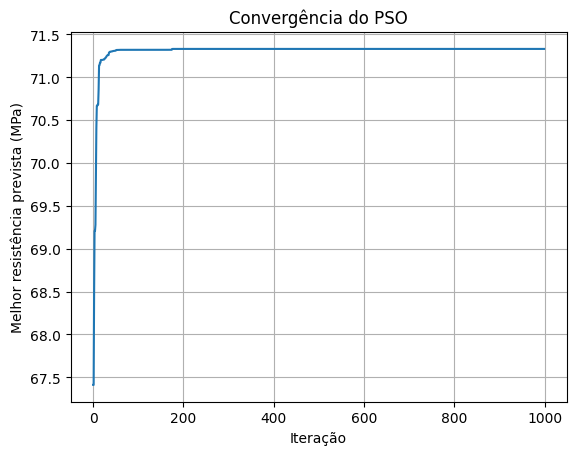

In [13]:
best_pos, best_strength, history = pso_optimize(
    n_particles=50,
    n_iterations=1000,
    w=0.5,
    c1=1.5,
    c2=1.5,
    seed=42
)

print("\n🔎 Melhor composição encontrada:")
for name, value in zip(feature_names, best_pos):
    print(f"  {name}: {value:.2f} kg/m³")
print(f"  Total: {np.sum(best_pos):.2f} kg/m³")
print(f"  Resistência prevista: {best_strength:.2f} MPa")

import matplotlib.pyplot as plt
plt.plot(history)
plt.xlabel("Iteração")
plt.ylabel("Melhor resistência prevista (MPa)")
plt.title("Convergência do PSO")
plt.grid()
plt.show()
